In [1]:
import numpy as np

import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')


import matplotlib.pyplot as plt
import seaborn as sns
from learning.collections_env.collections_env import CollectionsEnv
from learning.utils import misc
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization, SplineObservationWrapper
from learning.policies.dqn import DQNAgent, DefaultConfig

from dcc import Parameters, AAV, OAV

def construct_paths(name, log_num):
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    checkpoints_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'checkpoints')
    checkpoints = os.listdir(checkpoints_path)
    # print(f"Checkpoints: {checkpoints}")
    models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
    model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
    env_path =  os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'env.pkl')
    try:
        buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
    except:
        print('No buffer found.')

#     with open(buffer_path,'rb') as f:
#         buffer = pickle.load(f)
    return model_path

# LOADING

def load_agent(name, lognumber=0):
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    print(f"Logs available: {logs}")
    model_path = construct_paths(name, lognumber)
    os.listdir(model_path)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    return agent

def load_agent_from_path(model_path):
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    return agent

In [2]:
agent = load_agent("Vanilla4ActionsSplines50K", 0)

Logs available: ['20201215-215946', '20201215-215951']
[INFO] [2021-02-12 11:25:55,842] [C:\Projects\credit_collections_rl\learning\resources\models\Vanilla4ActionsSplines50K\20201215-215946] - Instantiated class DQNAgent
[WARNING] [2021-02-12 11:25:57,253] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-02-12 11:25:57,265] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


The saved environments are <SplineObservationWrapper<DiscretizedActionWrapper<CollectionsEnv instance>>>, the inheritance somehow blocks the state reset

In [3]:
def reinitialize_env(env_repl, shaping='discrete'):
    w0 = env_repl.w0
    params = Parameters()
    starting_state = np.array([1.0, w0], dtype='float')
    return CollectionsEnv(params=params, w0 = w0, reward_shaping=shaping, randomize_start=False, starting_state=starting_state)

In [7]:
env_repl = reinitialize_env(agent.env)

c:\users\markm\.conda\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [122]:
import dask
from copy import deepcopy

@dask.delayed
def single_value_parallel(env, state, policy=None):
    env = deepcopy(env)
    ob = env.reset(state)
    done = False
    reward = 0.
    df = np.exp(-env.params.rho * env.dt)
    while not done:
        # a, q = self.get_action(ob, epsilon=0.0)
        new_ob, r, done, _ = env.step(0)
        # self.env.render()
        reward += r * np.power(df, env.current_step) 
        ob = new_ob
    return reward

def mc_price_parallel(env, state, n_iter=1000):
    values = []
    for i in range(n_iter):
        values.append(single_value_parallel(env, state, policy=None))
    return dask.compute(values)
    

In [124]:
start_state=np.array([1.0, 200.0])
res = mc_price_parallel(env_repl, start_state, n_iter=1000)

In [130]:
%%timeit
res = mc_price_parallel(env_repl, start_state, n_iter=1000)

6.48 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
np.mean(res)

144.54787431979744

In [127]:
def single_value(env, state, policy=None, n_iter=10000):
    '''
    Parameters:
                env: collections_environment instance
                state : np.ndarray
    '''
    reward_history = []
#     steps = []
#     lams = []
#     bals = []
    if policy is None:
        a = 0.0
    df = np.exp(-env.params.rho * env.dt)
    for i in range(n_iter):
        ob = env.reset(state)
        done = False
        reward = 0.
        while not done:
            # a, q = self.get_action(ob, epsilon=0.0)
            new_ob, r, done, _ = env.step(a)
            # self.env.render()
            reward += r * np.power(df, env.current_step) 
            ob = new_ob
#             lams.append(env.current_state[0])
#             bals.append(env.current_state[1])
#             steps.append(env.current_step)
        reward_history.append(reward)
    return reward_history

In [113]:
np.exp(-env_repl.params.rho * env_repl.dt)

0.997004495503373

In [131]:
%%timeit
re = single_value(env_repl, state=np.array([1.0, 200.0]), n_iter=1000)

5.39 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [115]:
vals, steps, lams, bals = single_value(env_repl, state=np.array([1.0, 200.0]), n_iter=1000)

In [116]:
np.mean(vals)

150.18287180257136

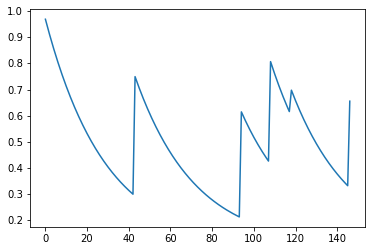

In [38]:
plt.plot(lams)

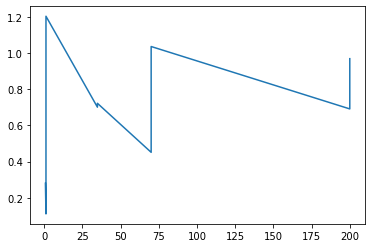

In [15]:
plt.plot(bals, lams)

In [197]:
np.array(steps) * 0.05

array([ 489.1 ,  556.25, 1135.5 , 1808.2 , 2320.7 ])

In [174]:
np.sum(vals)

2.0851522380983707e-10

In [42]:
aav= AAV(Parameters())

[INFO] [2021-02-12 11:28:51,983] [AAV] - Instantiated @ AAV


In [43]:
Parameters().rho

0.06

In [44]:
aav.u(1, 200)

-149.91674082730185

In [71]:
env_repl.reset(np.array([1.5, 20]))

array([ 1.5, 20. ])

In [72]:
env_repl.current_state

array([ 1.5, 20. ])

In [73]:
env_repl.step(0)

(array([ 1.45184758, 20.        ]), 0.0, False, None)